# Single-Server Queue (M/M/1)
## Scenario
- customers arrive randomly (exponentially distributed)
- infinte waiting room (unbounded queue)
- one service unit with random service time (exponentially distributed)
## Use Case
This simple setup can already simulate many use cases
- information desk at an airport
- station in manifacturing cell
- router in the internet
## Inspiration
- implementation based on the lecture "Simulation & Modeling" at FAU

In [29]:
# required imports
import numpy as np
from numpy.random import Generator, PCG64
import matplotlib.pyplot as plt

In [30]:
# randomness parameters
seed = 1234
rng = Generator(PCG64(seed=seed))

In [31]:
# simulation parameters
n = 30 # amount of customers to serve
servers = 1 # amount of servers
arrival_rate = 5 # time between each arrival
service_rate = 4 # time to serve a customer
arrival_distribution = rng.exponential
service_distribution = rng.exponential

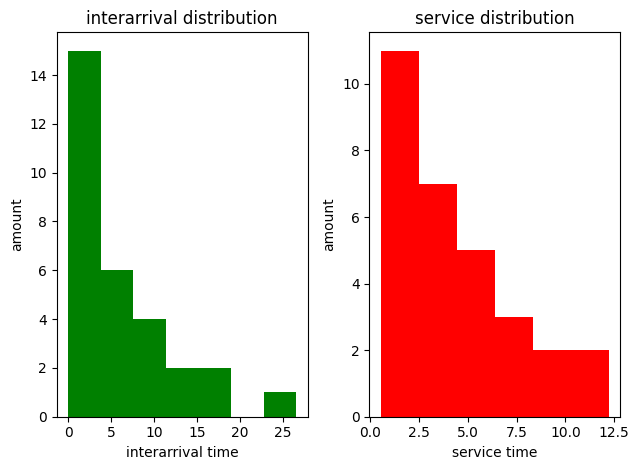

In [32]:
# histogram of example values for interarrival / service times
fig, ax = plt.subplots(1, 2, tight_layout=True)
ax[0].hist(arrival_distribution(scale=arrival_rate, size=n), bins='auto', color='g')
ax[1].hist(service_distribution(scale=service_rate, size=n), bins='auto', color='r')
ax[0].set(xlabel='interarrival time', ylabel='amount')
ax[1].set(xlabel='service time', ylabel='amount')
ax[0].set_title('interarrival distribution')
ax[1].set_title('service distribution')
plt.show()

In [33]:
class Simulation:
    def __init__(self, n, arrival_distribution, arrival_rate, service_distribution, service_rate, precision=3):
        # distributions
        self.arrival_distribution = arrival_distribution
        self.service_distribution = service_distribution
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        
        # event_list
        self.next_arrival_time = np.inf
        self.next_departure = np.inf
        
        # system state
        self.n = n
        self.clock = 0
        self.system = [] # extend to multiple servers in the future
        self.queue = []
        self.server_status = 0
        self.precision = precision
        
        # statistical counters
        self.number_served = 0
        self.total_waiting_time = 0
        self.total_system_time = 0 # delay/response time
        self.area_under_q = 0
        self.area_under_b = 0
        
        # statistical data to plot (list of the above)
        self.arrival_plot = [[0, 0]]
        self.departure_plot = [[0, 0]]
        self.number_in_system_plot = [[0, 0]]
        self.queue_plot = [[0, 0]]
    
    def generate_inter_arrival(self):
        return np.round(self.arrival_distribution(scale=self.arrival_rate), self.precision)
    
    def generate_service_time(self):
        return np.round(self.service_distribution(scale=self.service_rate), self.precision)
    
    def update_area_under_b(self, next_time):
        self.area_under_b += (next_time - self.clock) * self.server_status
    
    def update_area_under_q(self, next_time):
        self.area_under_q += (next_time - self.clock) * len(self.queue)
    
    def update_waiting_time(self):
        if len(self.queue) != 0:
            self.total_waiting_time += self.next_departure - self.queue[0]
        
    def update_system_time(self):
        if len(self.system) != 0:
            self.total_system_time += self.next_departure - self.system[0]
    
    def update_arrival_plot(self):
        self.arrival_plot.append([self.next_arrival_time, len(self.arrival_plot)])
        
    def update_departure_plot(self):
        self.departure_plot.append([self.next_departure, len(self.departure_plot)])
    
    def update_queue_plot(self):
        if len(self.queue) == 0:
            self.queue_plot.append([self.queue_plot[-1][0], 0])
        else:
            self.queue_plot.append([self.queue[-1], len(self.queue)])

    def arrival_handler(self):
        self.clock = self.next_arrival_time
        self.queue.append(self.next_arrival_time)
        self.next_arrival_time = self.clock + self.generate_inter_arrival()
        
        if self.server_status == 0:
            self.server_status = 1
            self.system.append(self.queue[0])
            self.queue = self.queue[1:]
            self.next_departure = self.clock + self.generate_service_time()

    def departure_handler(self):
        self.clock = self.next_departure
        self.number_served += 1
        
        if len(self.queue) != 0:
            self.system[0] = self.queue[0]
            self.queue = self.queue[1:]
            self.next_departure = self.clock + self.generate_service_time()
        else:
            self.next_departure = np.inf
            self.server_status = 0
            self.system = self.system[1:]

    def run(self):
        self.next_arrival_time = self.generate_inter_arrival()
        while self.number_served < n:
            if self.next_arrival_time <= self.next_departure:
                self.update_area_under_b(self.next_arrival_time)
                self.update_area_under_q(self.next_arrival_time)
                self.update_arrival_plot()
                self.arrival_handler()
            else:
                self.update_area_under_b(self.next_departure)
                self.update_area_under_q(self.next_departure)
                self.update_waiting_time()
                self.update_system_time()
                self.update_departure_plot()
                self.departure_handler()
            self.update_queue_plot()
            
        self.calculate_customer_amount_plot()
        self.report()

    def report(self):
        mean_system_time = np.round(self.total_system_time / self.number_served, self.precision)
        mean_waiting_time = np.round(self.total_waiting_time / self.number_served, self.precision)
        mean_queue_length = np.round(self.area_under_q / self.clock, self.precision)
        mean_utilization = np.round(self.area_under_b / self.clock, self.precision)
        print(f'Customers served: {self.number_served}')
        print(f'Expected mean system time: {mean_system_time}')
        print(f'Expected mean waiting time: {mean_waiting_time}')
        print(f'Expected queue lenght: {mean_queue_length}')
        print(f'Expected utilisation: {mean_utilization}')
        
    # kind of ugly code but does the job
     # combine arrival time and departure time to get customer count at time t
    def calculate_customer_amount_plot(self):
        customer_count = 0
        arrival_idx = 1
        departure_idx = 1
        arrival_plot_length = len(des.arrival_plot)
        departure_plot_length = len(des.departure_plot)
        while arrival_idx < arrival_plot_length and departure_idx < departure_plot_length:
            if des.arrival_plot[arrival_idx][0] < des.departure_plot[departure_idx][0]:
                customer_count += 1
                self.number_in_system_plot.append([des.arrival_plot[arrival_idx][0], customer_count])
                arrival_idx += 1
            else:
                customer_count -= 1
                self.number_in_system_plot.append([des.departure_plot[departure_idx][0], customer_count])
                departure_idx += 1

        while arrival_idx < arrival_plot_length:
            customer_count += 1
            self.number_in_system_plot.append([des.arrival_plot[arrival_idx][0], customer_count])
            arrival_idx += 1

        while departure_idx < departure_plot_length:
            customer_count -= 1
            self.number_in_system_plot.append([des.departure_plot[departure_idx][0], customer_count])
            departure_idx += 1
        

In [34]:
des = Simulation(n, arrival_distribution, arrival_rate, service_distribution, service_rate)
des.run()

Customers served: 30
Expected mean system time: 6.156
Expected mean waiting time: 3.387
Expected queue lenght: 0.632
Expected utilisation: 0.517


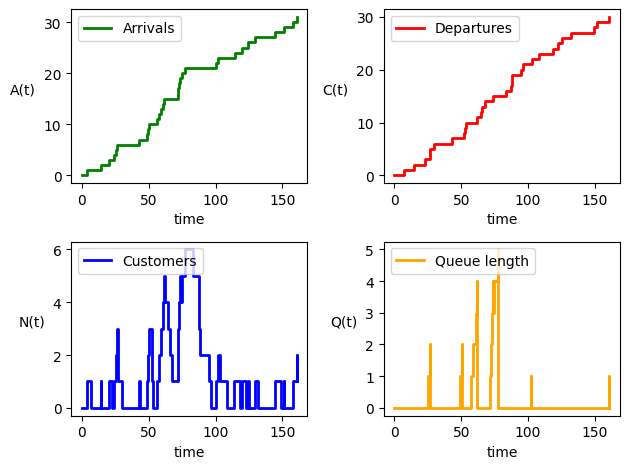

In [35]:
# plot customer numbers over time
fig, ax = plt.subplots(2, 2, tight_layout=True)
ax[0,0].step([d[0] for d in des.arrival_plot], [d[1] for d in des.arrival_plot], 'g', where='post', label='Arrivals', linewidth=2)
ax[0,1].step([d[0] for d in des.departure_plot], [d[1] for d in des.departure_plot], 'r', where='post', label='Departures', linewidth=2)
ax[1,0].step([d[0] for d in des.number_in_system_plot], [d[1] for d in des.number_in_system_plot], 'b', where='post', label='Customers', linewidth=2)
ax[1,1].step([d[0] for d in des.queue_plot], [d[1] for d in des.queue_plot], color='orange', where='post', label='Queue length', linewidth=2)

ax[0,0].set_xlabel('time')
ax[0,0].set_ylabel('A(t)', rotation=0, labelpad=15)
ax[0,1].set_xlabel('time')
ax[0,1].set_ylabel('C(t)', rotation=0, labelpad=15)
ax[1,0].set_xlabel('time')
ax[1,0].set_ylabel('N(t)', rotation=0, labelpad=15)
ax[1,1].set_xlabel('time')
ax[1,1].set_ylabel('Q(t)', rotation=0, labelpad=15)

for a in ax.flat:
    a.legend(loc="upper left")
plt.show()